#### Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import scipy.stats as stats
import seaborn as sns
import squarify
from typing import List, Dict, Any
import itertools
import math

#### Exploration

In [98]:

def load_data():
    return pd.read_csv('british_airways_bookings.csv', encoding="ISO-8859-1", header=0).reset_index(drop=True)

def get_binary_ratios(df, binary_columns):
   
    binary_ratios = {}

    for col in binary_columns:
        binary_ratios[col] = df[col].value_counts(normalize=True).to_dict()
    
    return {k: v for k, v in sorted(binary_ratios.items(), key=lambda item: item[1][1], reverse=True)}


def plot_binary_ratios(binary_ratios):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (col, ratios) in enumerate(binary_ratios.items()):
        ax.barh(i, ratios[1], color='purple', label=col)
        ax.barh(i, ratios[0], left=ratios[1], color='orange')
    ax.set_yticks(range(len(binary_ratios)))
    ax.set_yticklabels(binary_ratios.keys())
    ax.set_xlabel('Proportion')
    ax.set_title('Binary Column Ratios')
    plt.legend(['1', '0'])
    plt.show()
    
def plot_categorical_proportions(proportions, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (col, df) in enumerate(proportions.items()):
        ax.barh(df[col], df['percentage'], label=col)
    ax.set_xlabel('Proportion')
    ax.set_title(title)
    plt.legend()
    plt.show()

def merge_proportion_dfs(proportion_dfs: List[pd.DataFrame]) -> pd.DataFrame:
    modified_dfs = []

    for df in proportion_dfs:
        category_name = df.columns[0]
        df['category'] = category_name
        df.rename(columns={category_name: 'subcategory'}, inplace=True)
        modified_dfs.append(df)
    
    combined_df = pd.concat(modified_dfs, ignore_index=True)
    combined_df = combined_df[['category', 'subcategory', 'count', 'percentage']]
    
    return combined_df

def get_proportions(df, categorical_columns):
 
    proportions = []
    for column in categorical_columns:
        column_value_counts = df[column].value_counts().reset_index()
        column_value_counts.columns = [column, 'count']
        column_value_counts['percentage'] = ((column_value_counts['count'] / column_value_counts['count'].sum()) * 100).round(2)
        
        if column_value_counts.shape[0] > 5:
            column_value_counts = column_value_counts.head(5)
        
        column_value_counts = column_value_counts.sort_values(by='percentage', ascending=False).reset_index(drop=True)
        proportions.append(column_value_counts)
    
    return proportions

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_stacked_bar_chart_with_names(data: pd.DataFrame):
    """
    Creates a stacked bar chart with subcategory names and percentage values on the bars.
    
    Args:
        data (pd.DataFrame): DataFrame with 'category', 'subcategory', and 'percentage' columns.
                             The 'percentage' column should contain the raw values that will
                             be normalized to sum to 100% for each category.
    """
    pivot_df = data.pivot(index='category', columns='subcategory', values='percentage').fillna(0)
    # Normalize data to represent 100% for each category
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    
    categories = pivot_df.index
    subcategories = pivot_df.columns
    
    # Ensure consistent color mapping for subcategories
    unique_subcats_ordered = data['subcategory'].unique() # Keep original order for consistent legend if desired
    # Or use sorted unique subcategories if a specific order is preferred:
    # unique_subcats_ordered = sorted(data['subcategory'].unique()) 

    # Using a Tab20 colormap which has 20 distinct colors. 
    # If you have more than 20 subcategories, consider a different colormap or logic.
    num_unique_subcats = len(unique_subcats_ordered)
    colors = plt.cm.get_cmap('tab20', num_unique_subcats) # type: ignore
    color_map = {subcat: colors(i) for i, subcat in enumerate(unique_subcats_ordered)}
    
    fig, ax = plt.subplots(figsize=(12, 7), constrained_layout=True) # Increased figsize for better readability
    
    bar_height = 0.8 
    y_pos = np.arange(len(categories)) 
    
    left = np.zeros(len(categories))
    
    for subcat in subcategories: # Iterate through subcategories (columns of pivot_df)
        values = pivot_df[subcat]
        ax.barh(
            y=y_pos,
            width=values,
            left=left,
            height=bar_height,
            label=subcat,
            color=color_map[subcat],
            edgecolor='white',
            linewidth=0.5
        )
        
        # Add text (subcategory name and percentage) on each segment
        for i, val in enumerate(values): # 'i' is the index for the main category
            if val > 5: # Only add text for segments larger than 5%
                # Display subcategory name and its percentage
                text_label = f"{subcat}\n{val:.1f}%"
                ax.text(
                    x=left[i] + val / 2,
                    y=y_pos[i],
                    s=text_label,
                    va='center',
                    ha='center',
                    color='black' if val > 15 else 'white', # Adjust color for readability
                    fontsize=8, # Slightly reduced fontsize for two lines
                    fontweight='bold'
                )
        left += values
    
    ax.set_title('Proportional Distribution of Subcategories Within Each Category', pad=20, fontsize=16)
    ax.set_xlabel('Percentage Distribution (%)', fontsize=12)
    ax.set_ylabel('Category', fontsize=12) # Added Y-axis label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories, fontsize=10)
    ax.set_xlim(0, 100)
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    
    # Reorder legend handles and labels to match the stacking order (optional, but often preferred)
    handles, labels = ax.get_legend_handles_labels()
    # To match visual order (bottom to top stack with legend top to bottom)
    # or use pivot_df.columns for the order if specific:
    # ordered_legend_labels = [col for col in pivot_df.columns if col in labels]
    # ordered_handles = [handles[labels.index(lbl)] for lbl in ordered_legend_labels]

    # ax.legend(
    #     # handles[::-1], labels[::-1], # Reverse order if stacking is from bottom up in code
    #     handles, labels, # Keep order as generated if that's preferred
    #     title='Subcategories',
    #     bbox_to_anchor=(1.05, 1),
    #     loc='upper left',
    #     framealpha=1,
    #     fontsize=10,
    #     title_fontsize=12
    # )

    ax.set_ylim(-0.5, len(categories) - 0.5)
    
    # Ensure everything fits
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend if constrained_layout is not enough
    plt.show()
    

def create_stacked_bar_chart(data: pd.DataFrame):

    pivot_df = data.pivot(index='category', columns='subcategory', values='percentage').fillna(0)
    pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    
    categories = pivot_df.index
    subcategories = pivot_df.columns
    
    unique_subcats = data['subcategory'].unique()
    color_map = {subcat: plt.cm.tab20(i) for i, subcat in enumerate(unique_subcats)} # type: ignore
    
    fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
    
    bar_height = 0.8 
    y_pos = np.arange(len(categories)) 
    
    left = np.zeros(len(categories))
    
    for subcat in subcategories:
        values = pivot_df[subcat]
        ax.barh(
            y=y_pos,
            width=values,
            left=left,
            height=bar_height,
            label=subcat,
            color=color_map[subcat],
            edgecolor='white',
            linewidth=0.5
        )
        
        for i, (val, category) in enumerate(zip(values, categories)):
            if val > 5:
                ax.text(
                    x=left[i] + val/2,
                    y=y_pos[i],
                    s=f"{val:.1f}%",
                    va='center',
                    ha='center',
                    color='white' if val > 15 else 'black',  
                    fontsize=9,
                    fontweight='bold'
                )
        left += values
    
    ax.set_title('Proportional Distribution of Subcategories Within Each Category', pad=20)
    ax.set_xlabel('Percentage Distribution')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories)
    ax.set_xlim(0, 100)
    ax.grid(axis='x', linestyle=':', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles[::-1], labels[::-1],
        title='Subcategories',
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        framealpha=1
    )

    ax.set_ylim(-0.5, len(categories)-0.5)
    
    plt.show()

def plot_normality_grid(df, numerical_columns, figsize=(15, 10)):

    if isinstance(numerical_columns, pd.Series) or isinstance(numerical_columns, np.ndarray):
        cols = df.columns[numerical_columns]
    else:
        cols = numerical_columns
    
    n_cols = len(cols)
    if n_cols == 0:
        print("No numerical columns selected!")
        return
    
    fig, axes = plt.subplots(n_cols, 2, figsize=figsize)
    fig.tight_layout(pad=4.0)
    
    if n_cols == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(cols):
        data = df[col].dropna()
        
        ax_hist = axes[i, 0]
        ax_hist.hist(data, bins='auto', density=True, alpha=0.6, color='skyblue')
        
        mu, std = stats.norm.fit(data)
        xmin, xmax = ax_hist.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        ax_hist.plot(x, p, 'r', linewidth=2)
        ax_hist.set_title(f'{col}\nHistogram + Normal Fit')
        ax_hist.set_ylabel('Density')
        
        ax_qq = axes[i, 1]
        stats.probplot(data, dist="norm", plot=ax_qq)
        ax_qq.set_title(f'Q-Q Plot')
        ax_qq.get_lines()[0].set_markersize(4.0)
        ax_qq.get_lines()[0].set_markerfacecolor('steelblue')
        ax_qq.get_lines()[1].set_color('red')
    
    plt.suptitle('Normality Check for Numerical Columns', y=1.02, fontsize=14)
    plt.show()

def get_skewness(df: pd.DataFrame, numerical_columns: list) -> Dict[str, Dict[str, Any]]:

    results = {}
    
    for col in numerical_columns:
        skewness = df[col].skew()
        kurtosis = df[col].kurtosis()
        
        if skewness > 0:
            skew_dir = 'right'
        elif skewness < 0:
            skew_dir = 'left'
        else:
            skew_dir = 'normal'
        
        if kurtosis > 3:
            kurtosis_type = 'leptokurtic (heavy-tailed)'
        elif kurtosis < 3:
            kurtosis_type = 'platykurtic (light-tailed)'
        else:
            kurtosis_type = 'mesokurtic (normal)'
        
        results[col] = {
            'skewness': round(skewness, 4),
            'skewness_direction': skew_dir,
            'kurtosis': round(kurtosis, 4),
            'kurtosis_type': kurtosis_type,
            'is_normal': abs(skewness) < 0.5 and abs(kurtosis - 3) < 1 
        }
    
    return results

def calculate_booking_uplift(df, 
                           features=['wants_extra_baggage', 'wants_in_flight_meals', 'wants_preferred_seat'], 
                           target='booking_complete'):

    results = []
    
    for feature in features:
        grouped = df.groupby(feature)[target].mean()
        rate_0 = grouped.get(0, 0) * 100 
        rate_1 = grouped.get(1, 0) * 100
        
        abs_uplift = rate_1 - rate_0
        rel_uplift = (rate_1 - rate_0) / rate_0 if rate_0 != 0 else 0
        
        results.append({
            'feature': feature,
            'rate_0': round(rate_0, 2),
            'rate_1': round(rate_1, 2),
            'abs_uplift': round(abs_uplift, 2),
            'rel_uplift': f"{round(rel_uplift * 100, 2)}%"
        })
    
    return pd.DataFrame(results).sort_values('abs_uplift', ascending=False)

def plot_binary_uplift(uplift_df):
    features = uplift_df['feature'].tolist()
    rate_0 = uplift_df['rate_0'].tolist()
    rate_1 = uplift_df['rate_1'].tolist()
    rel_uplifts = uplift_df['rel_uplift'].tolist()
    uplifts =  [uplift_df['abs_uplift'][i] for i in range(len(uplift_df))]

    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(features))

    ax.barh(y_pos - 0.15, rate_0, height=0.3, color='#1f77b4', label='Not Selected (0)')
    ax.barh(y_pos + 0.15, rate_1, height=0.3, color='#ff7f0e', label='Selected (1)')

    
    for i, uplift in enumerate(uplifts):
        ax.annotate(f'+{uplift}%/{rel_uplifts[i]}', xy=(rate_0[i] + uplift/2, i), 
                    ha='center', va='center', fontweight='bold')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)
    ax.set_xlabel('Booking Completion Rate (%)')
    ax.set_title('Booking Rates by Feature Selection')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_binary_combination_impact(df):
    
    plot_df = df.copy()
    plot_df['combination'] = plot_df.apply(
        lambda x: f"{int(x['extra_baggage'])},{int(x['in_flight_meals'])},{int(x['preferred_seat'])}", axis=1
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='booking_rate', 
        y='combination', 
        data=plot_df.sort_values('booking_rate', ascending=False),
        palette='viridis'
    )
    plt.xlabel('Booking Rate (%)')
    plt.ylabel('Feature Combination (Baggage,Meals,Seat)')
    plt.title('Booking Rates by Feature Combinations')
    plt.axvline(x=10.67, color='red', linestyle='--', label='Baseline (0,0,0)')
    plt.legend()
    plt.show()

def get_binary_combination_impact(df):
    combinations = list(itertools.product([0, 1], repeat=3))
    results = []
    for combo in combinations:
        mask = (
            (df['wants_extra_baggage'] == combo[0]) & 
            (df['wants_in_flight_meals'] == combo[1]) & 
            (df['wants_preferred_seat'] == combo[2])
        )
        
        subset = df[mask]
        booking_rate = subset['booking_complete'].mean() * 100
        count = len(subset)
        
        results.append({
            'extra_baggage': combo[0],
            'in_flight_meals': combo[1],
            'preferred_seat': combo[2],
            'booking_rate': round(booking_rate, 2),
            'count': count
        })
    combo_df = pd.DataFrame(results)
    combo_df.sort_values('booking_rate', ascending=False)
    return combo_df

def plot_histograms_grid(df, numerical_columns, n_cols=3, figsize=(15, 10)):

    n_rows = math.ceil(len(numerical_columns) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Distribution of Numerical Columns', y=1.02)
    
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    for i, col in enumerate(numerical_columns):
        ax = axes[i]
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        ax.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
    
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_enhanced_histograms(df, cols, n_cols=3, figsize=(18, 12)):
    n_rows = math.ceil(len(cols)/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    for i, col in enumerate(cols):
        ax = axes[i//n_cols, i%n_cols] if n_rows > 1 else axes[i]
        
        sns.histplot(df[col], bins=30, kde=True, ax=ax)
        
        # Add statistical markers
        stats = {
            'Mean': df[col].mean(),
            'Median': df[col].median(),
            'Mode': df[col].mode()[0],
            'Q1-Q3': (df[col].quantile(0.25), df[col].quantile(0.75))
        }
        
        ax.axvline(stats['Mean'], color='red', linestyle='--', label=f"Mean: {stats['Mean']:.1f}")
        ax.axvline(stats['Median'], color='green', linestyle='-', label=f"Median: {stats['Median']:.1f}")
        ax.axvspan(*stats['Q1-Q3'], alpha=0.1, color='blue', label=f"IQR: {stats['Q1-Q3'][0]:.1f}-{stats['Q1-Q3'][1]:.1f}")
        
        ax.set_title(f"{col}\n(Skew: {df[col].skew():.2f}, Kurtosis: {df[col].kurtosis():.2f})")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

### EDA

#### Binary Features


To start our analysis , lets first inspect the different types of features we have

In [42]:
df = load_data()
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [43]:
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [44]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


From the description we can see that we are dealing different types of numerical columns, several categorical columns and the numerical columns, include binary, continuous, and discrete columns. We can also see that the standard deviation for `purchase_lead` and `length_of_stay` is high showing high variance and skewness.  We will have to seperate the different types of features and inspect them one at a time. We also do not seem to have any missing values. Lets start with separating the features and then inspecting the ones with binary values.

In [45]:

df = load_data()

categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
binary_columns = df[df.columns[df.nunique() == 2]].select_dtypes(include=['int64']).columns.tolist()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = list(set(categorical_columns) - set(binary_columns))
numerical_columns = list(set(numerical_columns) - set(binary_columns))
target_column = 'booking_complete'

To understand the binary features, we calculate the ratio of values for each category.

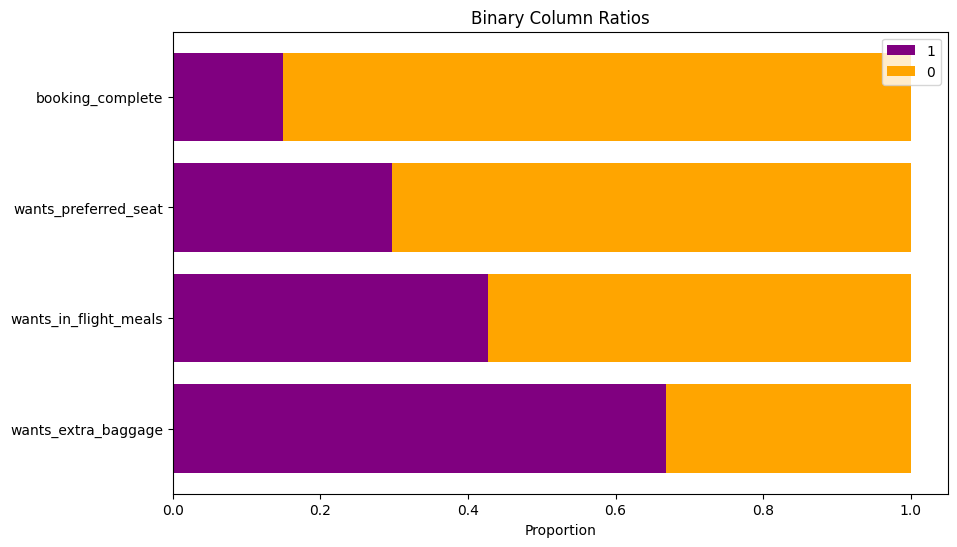

In [46]:
binary_ratios = get_binary_ratios(df, binary_columns)
plot_binary_ratios(binary_ratios)

From the above plot, we can see that around 70% of people want extra baggage, less than 50% want in flight meals, less than 40% want preferred seat and overall, only 20% of people end up completing the booking. Lets analyse the impact of the three features and booking completion. 

In [ ]:
uplift_df = calculate_booking_uplift(df)
plot_binary_uplift(uplift_df)

,feature,rate_0,rate_1,abs_uplift,rel_uplift
0,wants_extra_baggage,11.50,16.67,5.16,44.89%
2,wants_preferred_seat,13.79,17.71,3.91,28.36%
1,wants_in_flight_meals,14.14,16.05,1.91,13.52%


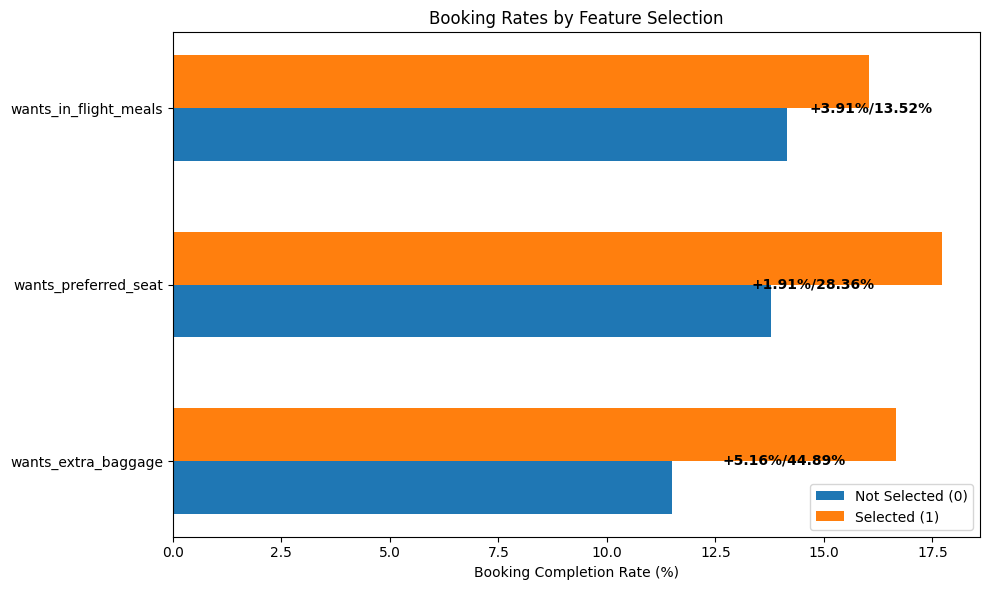

###### **Extra Baggage**
Inspecting the impact indivually shows us that `wants_extra_baggage` has **5.16%** increase in completion rate when selected from **11.5%** to **16.7%** which means that customers committing to bagage are **45%** more likely to complete the booking. 
###### **Preferred Seats**
This feature also seems to have high impact with **28%** uplift from **13.8% to **17.7%** showing that seat selection also indicates higher engagement.
###### **In-Flight Meals**
There seems to a marginal impact with only **14%** uplift with selection. 


To further analyse understand the impact of binary features, we can also analyse different combinations of all three features.

C:\Users\Danis\AppData\Local\Temp\ipykernel_42880\839816417.py:263: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


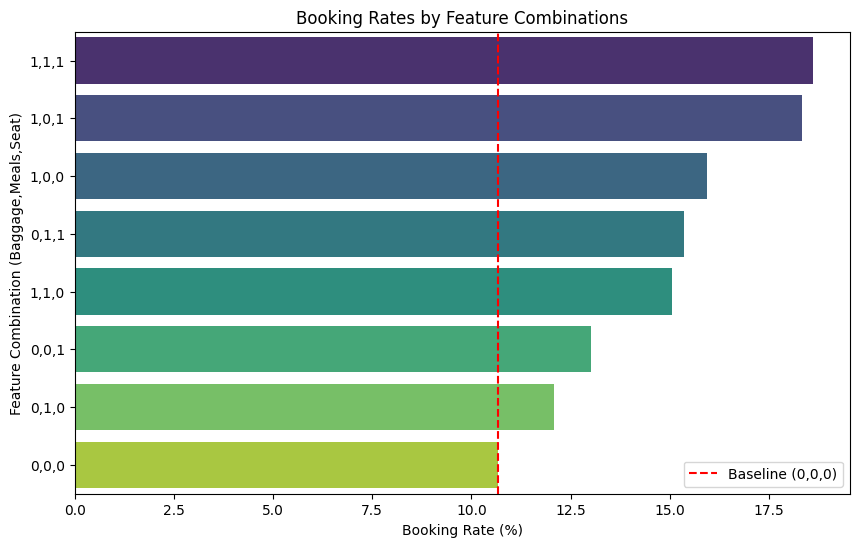

In [49]:
binary_combination_impact = get_binary_combination_impact(df)
plot_binary_combination_impact(binary_combination_impact)

The baseline case where customers do not add any services are least likely to complete the booking.  From the three services, in-flight meals seem to have the lowest impact on booking completion when other services are selected. The most impactful service extra is the `wants_extra_baggage`, it seems to drive the biggest uplift in comparison to other services. `wants_preferred_seat` also adds value when compared with `wants_extra_baggage`.

The incremental gain from (1,0,0) to (1,1,1) is only +2.67pp which suggests that baggage is the primary driver, with meal and seats providing marginal additional benefit.





#### Categorical Features

In [50]:
df[categorical_columns]

,sales_channel,booking_origin,route,flight_day,trip_type
0,Internet,New Zealand,AKLDEL,Sat,RoundTrip
1,Internet,New Zealand,AKLDEL,Sat,RoundTrip
2,Internet,India,AKLDEL,Wed,RoundTrip
3,Internet,New Zealand,AKLDEL,Sat,RoundTrip
4,Internet,India,AKLDEL,Wed,RoundTrip
...,...,...,...,...,...
49995,Internet,Australia,PERPNH,Sat,RoundTrip
49996,Internet,Australia,PERPNH,Sun,RoundTrip
49997,Internet,Australia,PERPNH,Sat,RoundTrip
49998,Internet,Australia,PERPNH,Mon,RoundTrip


In [51]:
categorical_columns

['sales_channel', 'booking_origin', 'route', 'flight_day', 'trip_type']

To get an overview of the proportions of each sub category wihtin the main category we are going to plot the proportions for the top 5 sub categories.

C:\Users\Danis\AppData\Local\Temp\ipykernel_42880\2639287621.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_unique_subcats) # type: ignore
C:\Users\Danis\AppData\Local\Temp\ipykernel_42880\2639287621.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x=left[i] + val / 2,
C:\Users\Danis\AppData\Local\Temp\ipykernel_42880\2639287621.py:162: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend if constrained_layout is not enough


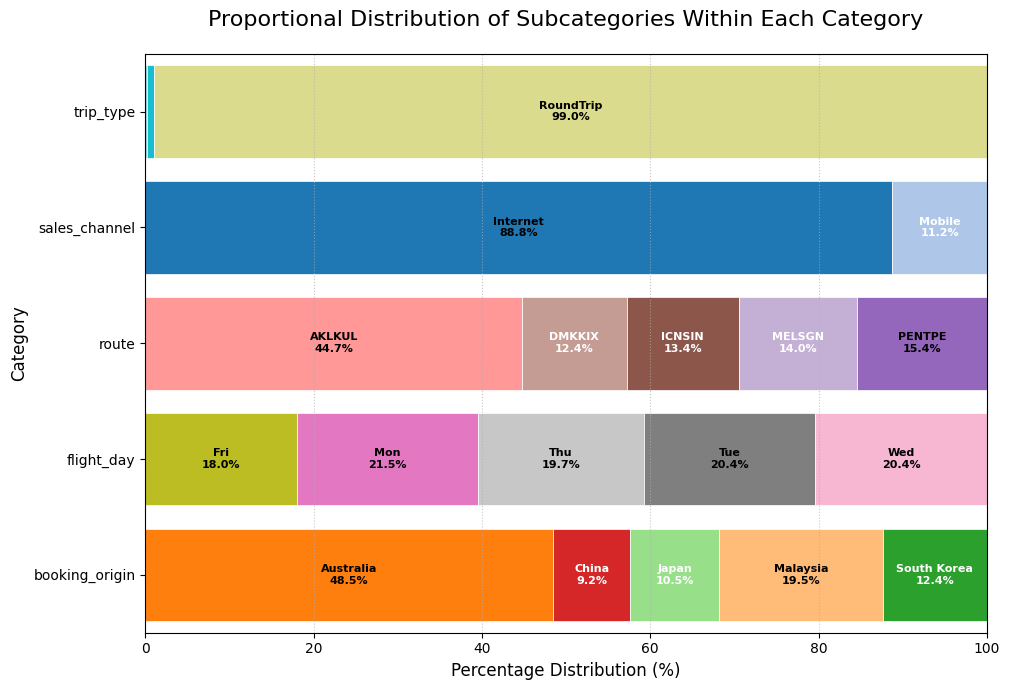

In [99]:
combined_proportions = merge_proportion_dfs(get_proportions(df, categorical_columns))
combined_proportions['percentage'] = combined_proportions['percentage'].astype(float)
create_stacked_bar_chart_with_names(combined_proportions)

To understand booking patterns across sub categories, we can plot a tree map.

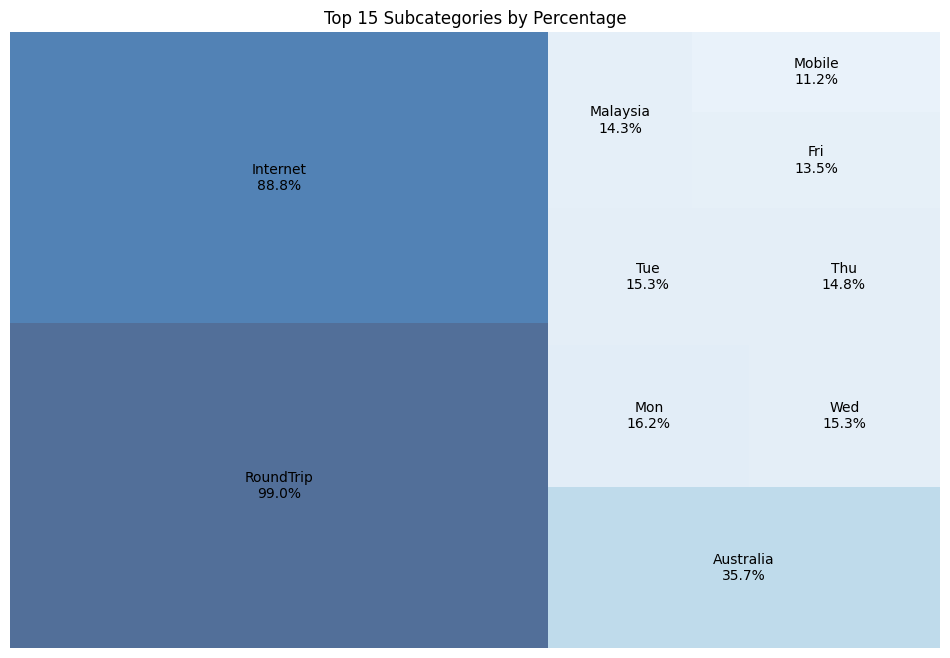

In [100]:
tree_data = combined_proportions.nlargest(10, 'percentage')

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=tree_data['percentage'],
    label=[f"{row['subcategory']}\n{row['percentage']:.1f}%" 
           for _, row in tree_data.iterrows()],
    color=plt.cm.Blues(tree_data['percentage']/100), # type: ignore
    alpha=0.7
)
plt.axis('off')
plt.title('Top 15 Subcategories by Percentage')
plt.show()

The treemap shows clear patterns across key bookings categories. Trip Type shows clear preference for RoundTrip flights (98.99%), while sales channels are heavily skewed toward Internet bookings (88.76% vs 11.24% for Mobile). Geographic distributions clear show Australia at the top with 35.7% of the bookings, while Malaysia is not-so-close second with 14.3%. Flight days  seem to maintain a balanced demand with Monday being the most popular (16.20%) and Friday least preferred (13.52%). 

This suggests :
- RoundTrip is the industry standard.
- Monday is the most popular day of the week at (16.20%) and Friday least preferred with 13.52%. 
- Majority of bookings (88.8%) come from online channels.

#### Non Binary Numerical Features

In [2]:
df[numerical_columns].describe()

NameError: name 'df' is not defined

In [1]:
df['flight_hour'].value_counts()

NameError: name 'df' is not defined

From the descriptive statistics we can see that `length_of_stay` and `purchase_lead` have very high variance. We can check the histograms to see how the data is distributed for each features.

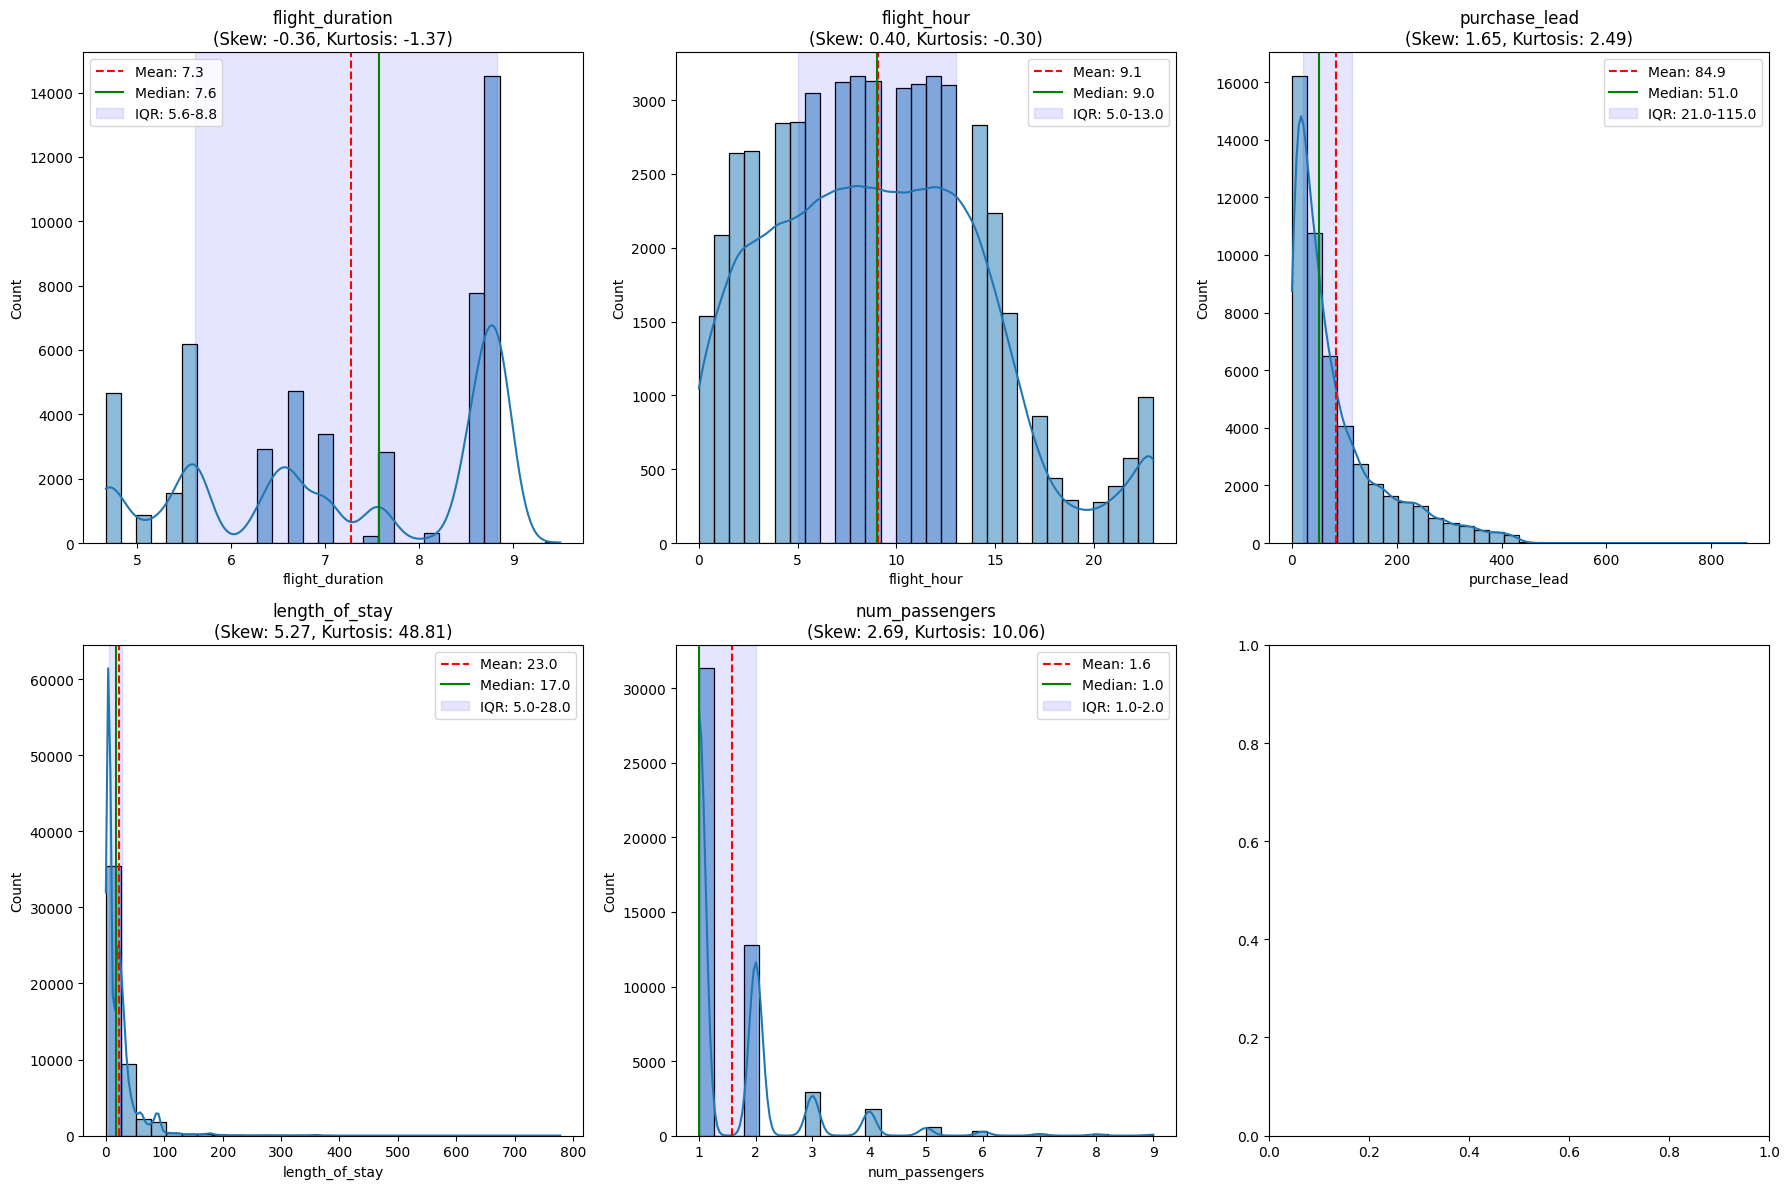

In [56]:
plot_enhanced_histograms(df, numerical_columns, n_cols=3, figsize=(18, 12))

From the histograms, we can see that none of the features are normally distributed and are heavily skewed. `flight_hour` seems to be the least skewed feature with the lowest kurtosis. `length_of_stay` and `purchase_lead` are  right-skewed with most values clustered at lower end with long tail. `num_passengers` is count data with spikes at whole numbers. `flight_duration` ranges from 5.6 hours to 8.8 hours with average flight being 7.3 hours long.

Next, we can plot histogram with q-q plots to check check for normality.

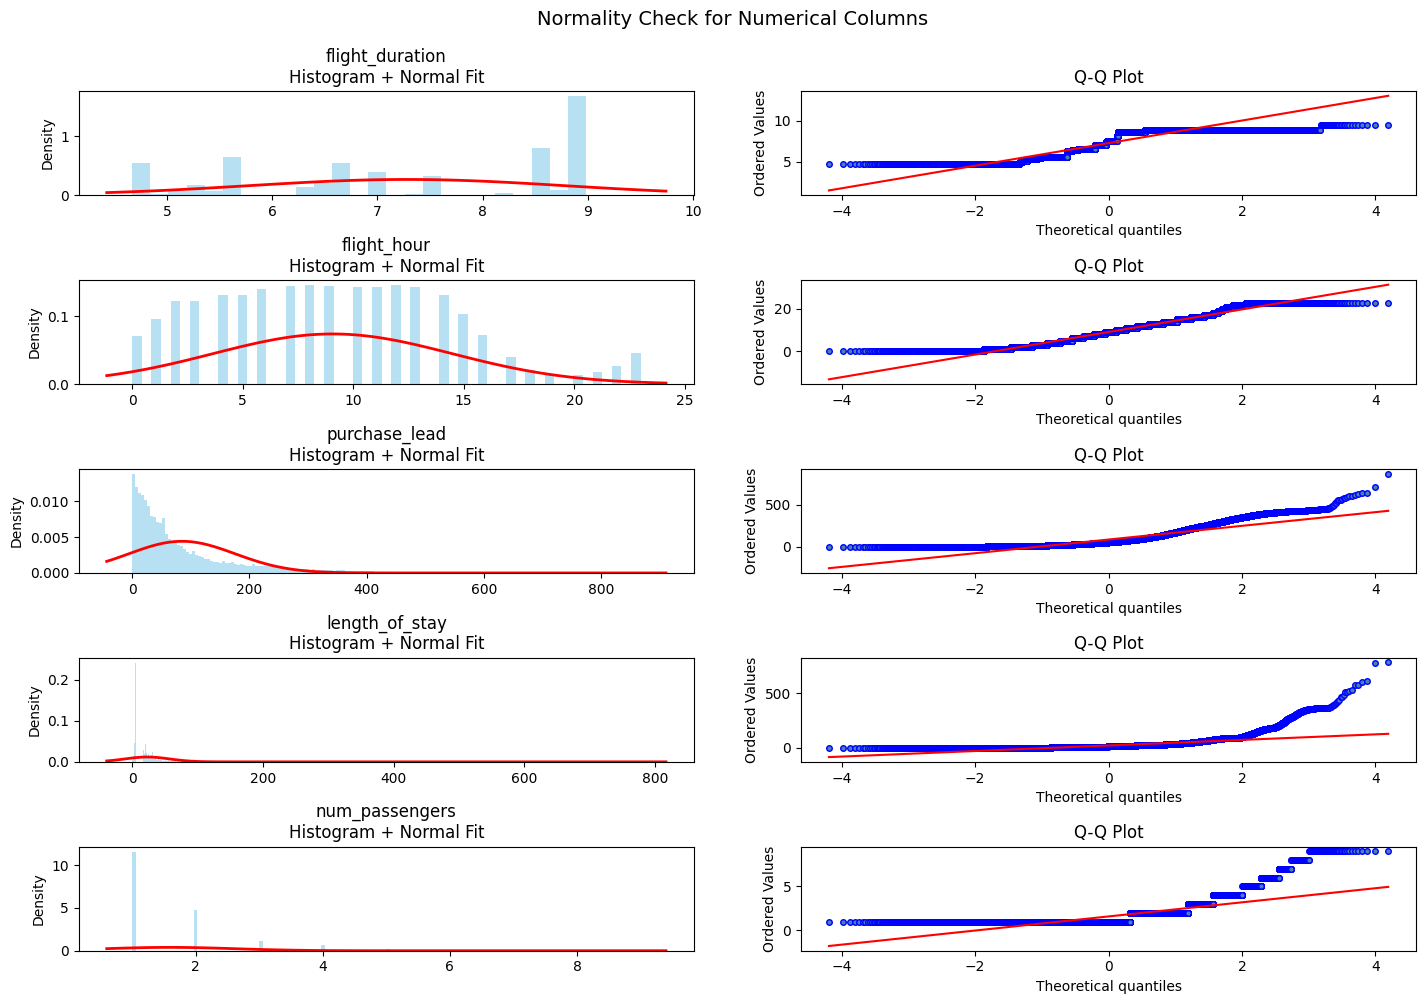

In [57]:
plot_normality_grid(df, numerical_columns)

In [58]:
numerical_columns

['flight_duration',
 'flight_hour',
 'purchase_lead',
 'length_of_stay',
 'num_passengers']

This confirms that none of the features are normally distributed. We can see that `purchase_lead` seems closest to normality. We can also use box plots to check for outliers.

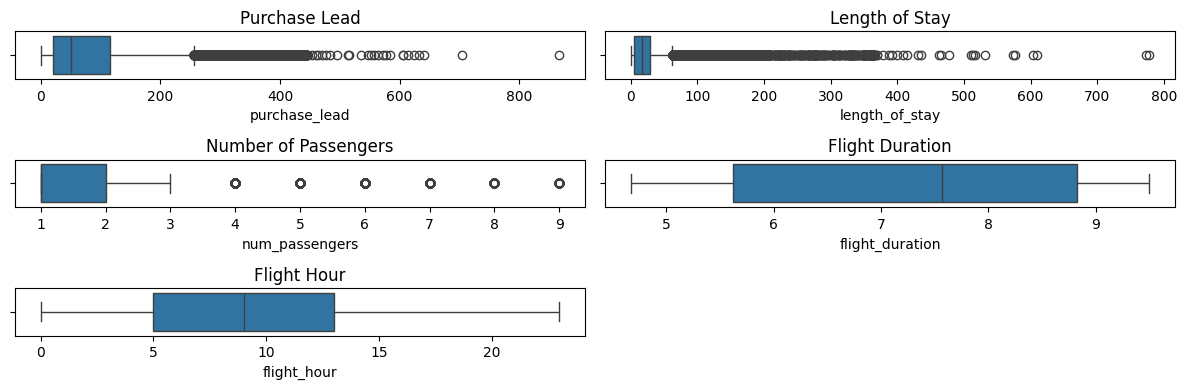

In [59]:
fig, axes_grid = plt.subplots(3, 2, figsize=(12, 4))

axes = axes_grid.flatten()

sns.boxplot(x=df['purchase_lead'], ax=axes[0])
axes[0].set_title('Purchase Lead')

sns.boxplot(x=df['length_of_stay'], ax=axes[1])
axes[1].set_title('Length of Stay')

sns.boxplot(x=df['num_passengers'], ax=axes[2])
axes[2].set_title('Number of Passengers')

sns.boxplot(x=df['flight_duration'], ax=axes[3])
axes[3].set_title('Flight Duration')

sns.boxplot(x=df['flight_hour'], ax=axes[4])
axes[4].set_title('Flight Hour')

axes[5].set_visible(False)

plt.tight_layout()

plt.show()

Purchase lead,  length of stay and num_passengers have a lot of outliers which should be removed.

#### Removing Outliers

In [60]:
all_numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in binary_columns:
    if col in all_numerical_columns:
        all_numerical_columns.remove(col)
all_numerical_columns.append(target_column)
df[all_numerical_columns].corr()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration,booking_complete
num_passengers,1.000000,0.212606,-0.115850,0.015607,-0.063169,0.024116
purchase_lead,0.212606,1.000000,-0.076560,0.035973,0.067866,-0.022131
length_of_stay,-0.115850,-0.076560,1.000000,-0.024872,0.141181,-0.042408
flight_hour,0.015607,0.035973,-0.024872,1.000000,-0.002101,0.007127
flight_duration,-0.063169,0.067866,0.141181,-0.002101,1.000000,-0.106266
booking_complete,0.024116,-0.022131,-0.042408,0.007127,-0.106266,1.000000


<Axes: >

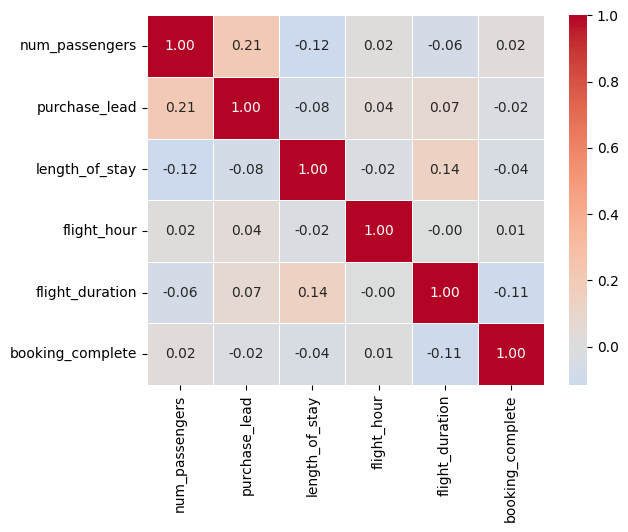

In [61]:
sns.heatmap(df[all_numerical_columns].corr(), annot=True,linewidth=.5, fmt=".2f", cmap='coolwarm', center=0)

In [62]:
skewness_results = get_skewness(df, numerical_columns)
for k,v in skewness_results.items():
    print(f"{k}: {v['skewness']} ({v['skewness_direction']})")
    print(f"  Kurtosis: {v['kurtosis']} ({v['kurtosis_type']})")
    print(f"  Is Normal: {v['is_normal']}")

flight_duration: -0.3601 (left)
  Kurtosis: -1.3739 (platykurtic (light-tailed))
  Is Normal: False
flight_hour: 0.3966 (right)
  Kurtosis: -0.3024 (platykurtic (light-tailed))
  Is Normal: False
purchase_lead: 1.653 (right)
  Kurtosis: 2.4867 (platykurtic (light-tailed))
  Is Normal: False
length_of_stay: 5.2747 (right)
  Kurtosis: 48.8102 (leptokurtic (heavy-tailed))
  Is Normal: False
num_passengers: 2.6909 (right)
  Kurtosis: 10.0621 (leptokurtic (heavy-tailed))
  Is Normal: False


#### Length of Stay

In [63]:
df['length_of_stay_log'] =  np.log1p(df['length_of_stay'])

##### Log Transformation

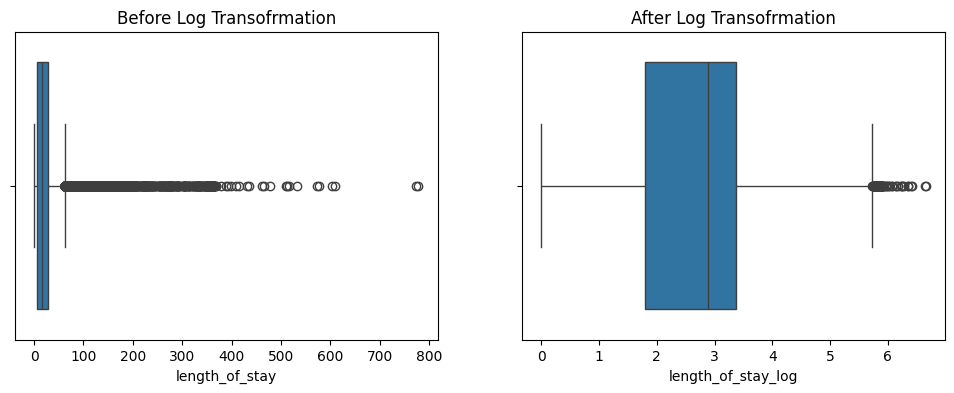

In [64]:

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['length_of_stay'], ax=axes[0]).set_title('Before Log Transofrmation')
sns.boxplot(x=df['length_of_stay_log'], ax=axes[1]).set_title('After Log Transofrmation')
plt.show()



##### Yeo Johnson Transformation

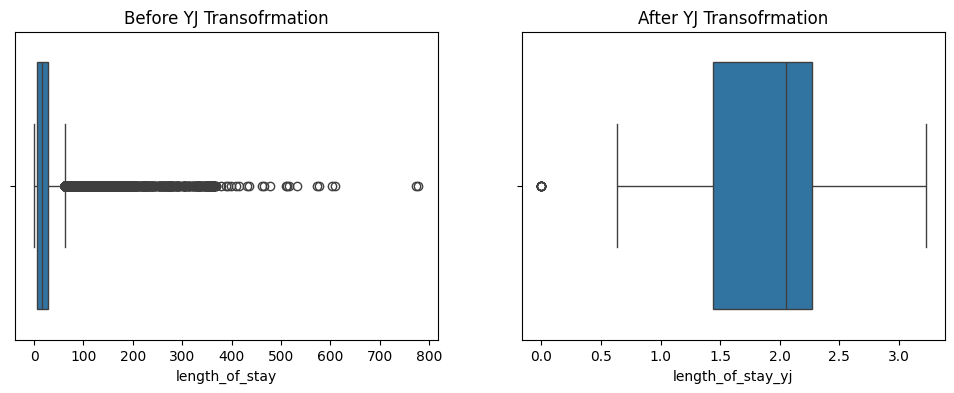

In [65]:
from scipy.stats import yeojohnson

df['length_of_stay_yj'], _ = yeojohnson(df['length_of_stay'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['length_of_stay'], ax=axes[0]).set_title('Before YJ Transofrmation')
sns.boxplot(x=df['length_of_stay_yj'], ax=axes[1]).set_title('After YJ Transofrmation')
plt.show()

##### Capping Length of Stay to remove the outlier

In [66]:
low_threshold = df['length_of_stay_yj'].quantile(0.01) 
df['length_of_stay_yj_capped'] = df['length_of_stay_yj'].clip(lower=low_threshold)


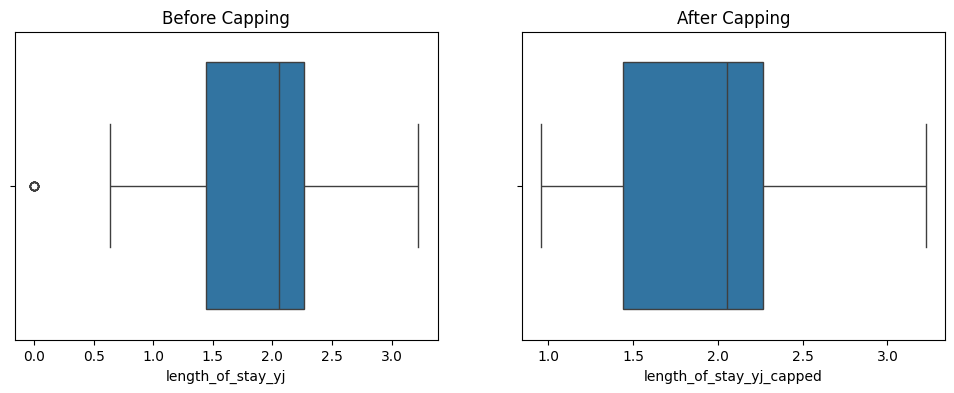

In [67]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['length_of_stay_yj'], ax=axes[0]).set_title('Before Capping')
sns.boxplot(x=df['length_of_stay_yj_capped'], ax=axes[1]).set_title('After Capping')
plt.show()

#### Number of Passengers


Text(0.5, 1.0, 'Num Passengers')

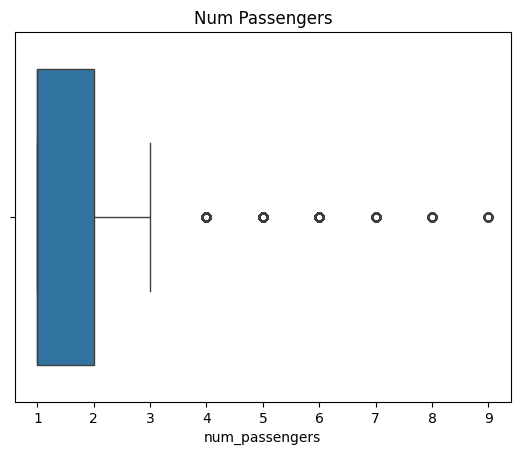

In [68]:
sns.boxplot(x=df['num_passengers']).set_title('Num Passengers')


##### Log Transformation

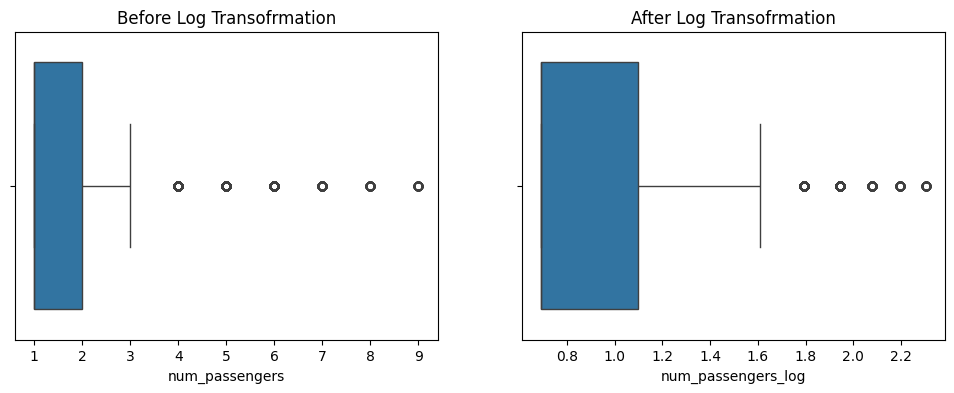

In [69]:
df['num_passengers_log'] =  np.log1p(df['num_passengers'])


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['num_passengers'], ax=axes[0]).set_title('Before Log Transofrmation')
sns.boxplot(x=df['num_passengers_log'], ax=axes[1]).set_title('After Log Transofrmation')
plt.show()

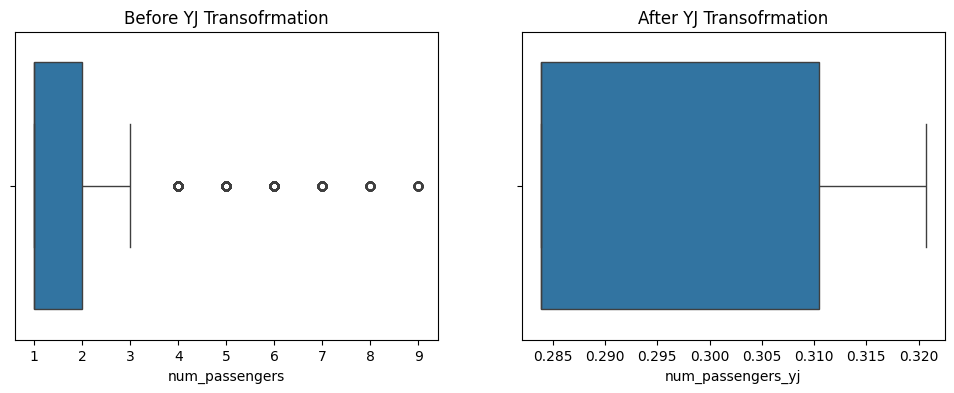

In [70]:

df['num_passengers_yj'], _ = yeojohnson(df['num_passengers'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['num_passengers'], ax=axes[0]).set_title('Before YJ Transofrmation')
sns.boxplot(x=df['num_passengers_yj'], ax=axes[1]).set_title('After YJ Transofrmation')
plt.show()

<!-- ['purchase_lead',
 'length_of_stay',
 'num_passengers',
 'flight_duration',
 'flight_hour' -->

#### Purchase Lead

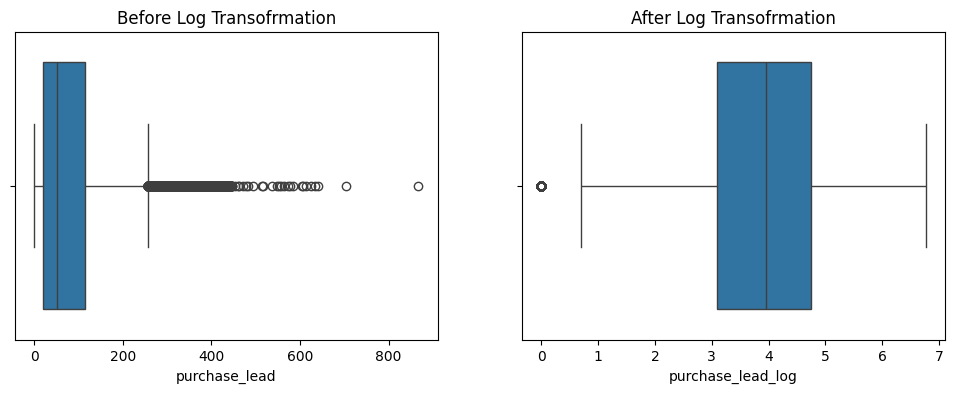

In [71]:
df['purchase_lead_log'] =  np.log1p(df['purchase_lead'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['purchase_lead'], ax=axes[0]).set_title('Before Log Transofrmation')
sns.boxplot(x=df['purchase_lead_log'], ax=axes[1]).set_title('After Log Transofrmation')
plt.show()

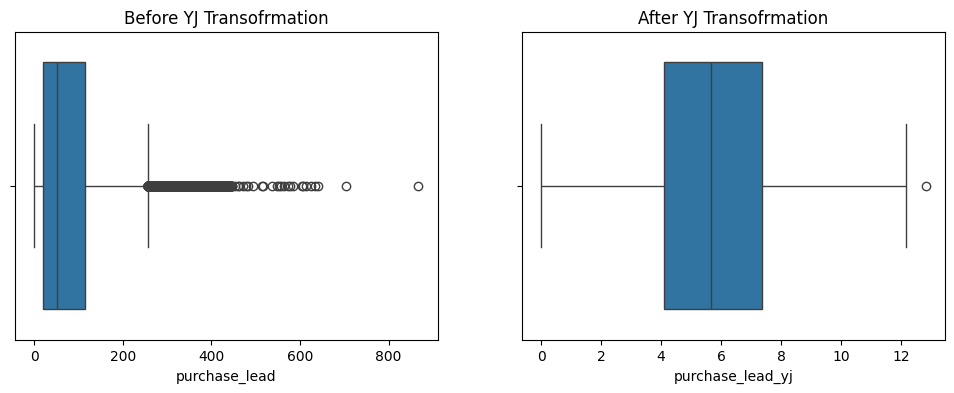

In [72]:

df['purchase_lead_yj'], _ = yeojohnson(df['purchase_lead'])
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(x=df['purchase_lead'], ax=axes[0]).set_title('Before YJ Transofrmation')
sns.boxplot(x=df['purchase_lead_yj'], ax=axes[1]).set_title('After YJ Transofrmation')
plt.show()

<!-- ['purchase_lead',
 'length_of_stay',
 'num_passengers',
 'flight_duration',
 'flight_hour' -->

In [73]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,wants_in_flight_meals,flight_duration,booking_complete,length_of_stay_log,length_of_stay_yj,length_of_stay_yj_capped,num_passengers_log,num_passengers_yj,purchase_lead_log,purchase_lead_yj
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,...,0,5.52,0,2.995732,2.102246,2.102246,1.098612,0.310462,5.572154,9.360982
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,...,0,5.52,0,3.044522,2.125020,2.125020,0.693147,0.283909,4.727388,7.305580
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,...,0,5.52,0,3.135494,2.166743,2.166743,1.098612,0.310462,5.497168,9.166181
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,...,1,5.52,0,3.465736,2.310406,2.310406,0.693147,0.283909,4.574711,6.965014
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,...,1,5.52,0,3.135494,2.166743,2.166743,1.098612,0.310462,4.234107,6.236811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,...,1,5.62,0,1.945910,1.537723,1.537723,1.098612,0.310462,3.332205,4.503013
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,...,0,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,4.718499,7.285506
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,...,1,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,3.218876,4.303615
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,...,1,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,2.772589,3.555212


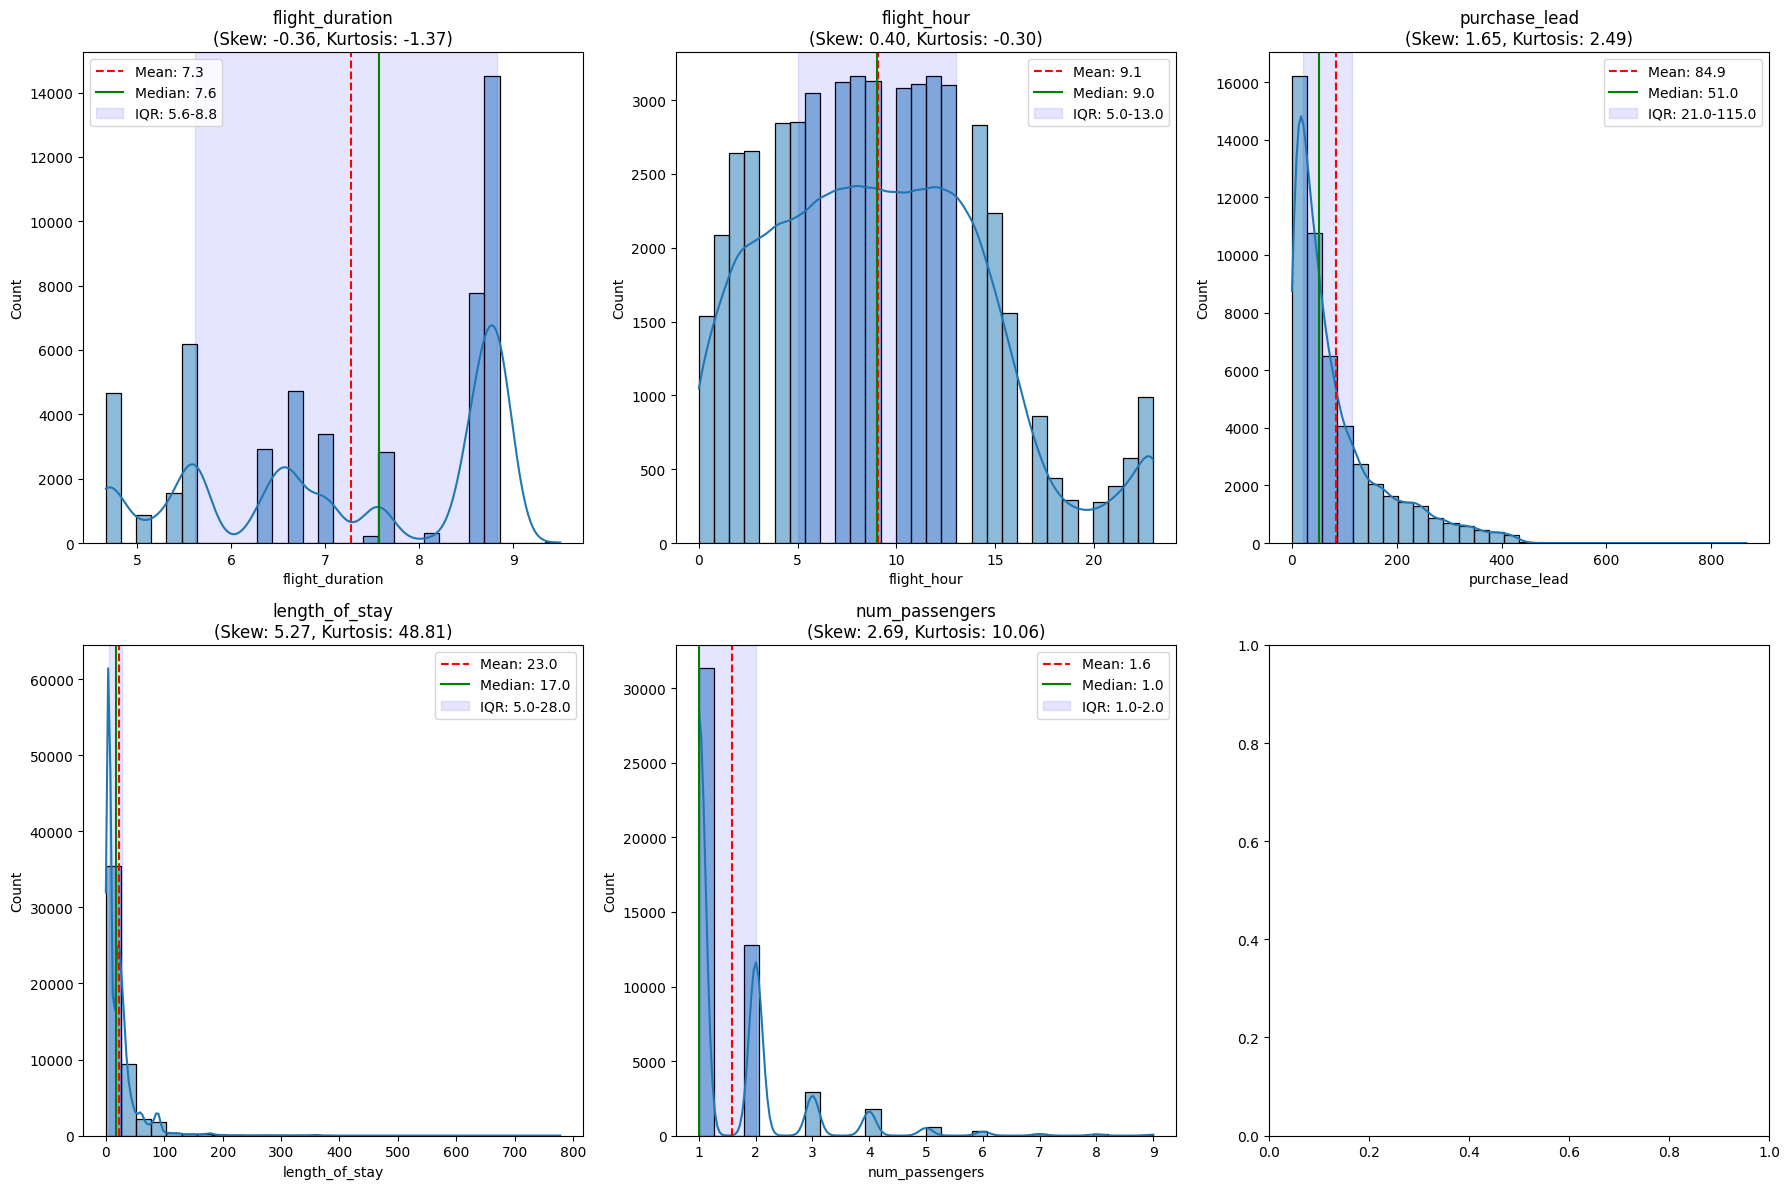

In [74]:
plot_enhanced_histograms(df, numerical_columns, n_cols=3, figsize=(18, 12))

sns.histplot(df['flight_hour'], kde=True)


In [83]:
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,wants_in_flight_meals,flight_duration,booking_complete,length_of_stay_log,length_of_stay_yj,length_of_stay_yj_capped,num_passengers_log,num_passengers_yj,purchase_lead_log,purchase_lead_yj
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,...,0,5.52,0,2.995732,2.102246,2.102246,1.098612,0.310462,5.572154,9.360982
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,...,0,5.52,0,3.044522,2.125020,2.125020,0.693147,0.283909,4.727388,7.305580
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,...,0,5.52,0,3.135494,2.166743,2.166743,1.098612,0.310462,5.497168,9.166181
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,...,1,5.52,0,3.465736,2.310406,2.310406,0.693147,0.283909,4.574711,6.965014
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,...,1,5.52,0,3.135494,2.166743,2.166743,1.098612,0.310462,4.234107,6.236811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,...,1,5.62,0,1.945910,1.537723,1.537723,1.098612,0.310462,3.332205,4.503013
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,...,0,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,4.718499,7.285506
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,...,1,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,3.218876,4.303615
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,...,1,5.62,0,1.945910,1.537723,1.537723,0.693147,0.283909,2.772589,3.555212


In [84]:
numerical_columns_transformed = ['length_of_stay_yj_capped', 'num_passengers_yj', 'purchase_lead_yj']

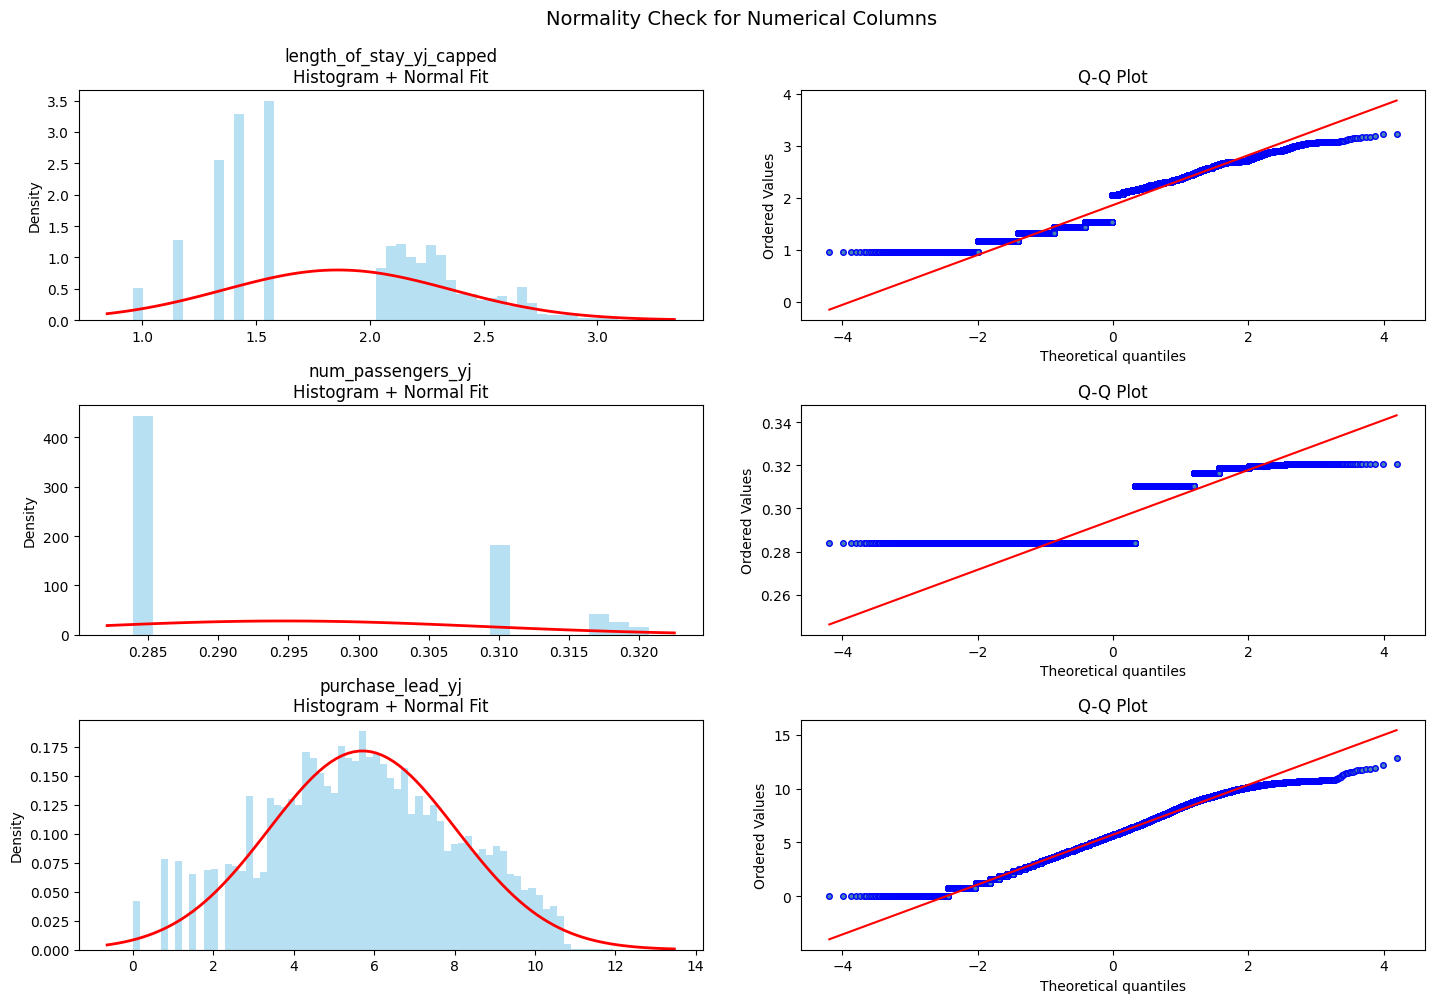

In [86]:
plot_normality_grid(df, numerical_columns_transformed)

After applying transformations and removing outliers, the distributions now look much better.

In [92]:
df_transformed = df[['sales_channel', 'trip_type', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'length_of_stay_yj_capped', 'num_passengers_yj', 'purchase_lead_yj']]

In [93]:
df_transformed

,sales_channel,trip_type,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,length_of_stay_yj_capped,num_passengers_yj,purchase_lead_yj
0,Internet,RoundTrip,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,2.102246,0.310462,9.360982
1,Internet,RoundTrip,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,2.125020,0.283909,7.305580
2,Internet,RoundTrip,17,Wed,AKLDEL,India,1,1,0,5.52,2.166743,0.310462,9.166181
3,Internet,RoundTrip,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,2.310406,0.283909,6.965014
4,Internet,RoundTrip,15,Wed,AKLDEL,India,1,0,1,5.52,2.166743,0.310462,6.236811
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Internet,RoundTrip,9,Sat,PERPNH,Australia,1,0,1,5.62,1.537723,0.310462,4.503013
49996,Internet,RoundTrip,4,Sun,PERPNH,Australia,0,0,0,5.62,1.537723,0.283909,7.285506
49997,Internet,RoundTrip,22,Sat,PERPNH,Australia,0,0,1,5.62,1.537723,0.283909,4.303615
49998,Internet,RoundTrip,11,Mon,PERPNH,Australia,1,0,1,5.62,1.537723,0.283909,3.555212
